The basic notebook can be found with the name `Fashion MNIST`. this notebook is also same as that one, but here we intorduce `Dropout` which is a mechanism through which Overfitting can be controlled.

In [1]:
#importing the libraries
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn
from torch import optim
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt


In [2]:
#defining the transformations for each image
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

#getting the data for training and testing
trainset = datasets.FashionMNIST('F_MNIST_data/', train=True, transform=transform, download=True)
testset = datasets.FashionMNIST('F_MNIST_data/', train=False, transform=transform, download=True)

#creation of generators that can be used to get images and labels of batch_size as defined
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

tensor(9)


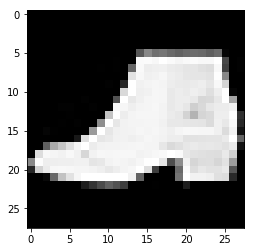

In [3]:
#Just visualising the data
images, labels = iter(trainloader).next()

print(labels[0])

plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r');

We could see that the `labels[0]` correspond to tensor(9) and the image shown is also a Boot

### Defining the model
This is one way of defining the model using `nn.Sequential`. There is also an another way of defining the model by sub classing `nn.Module`. Now in the model definition you can see that, I have used `nn.Dropout(0.2)` which is used to drop the nodes of network randomly which prevents overfitting. `0.2` specifies the probability with which each node should be disabled.

In [5]:
input_size = 784
hidden_size = [256, 128, 64]
output_size = 10


model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(input_size, hidden_size[0])),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.2)),
    ('fc2', nn.Linear(hidden_size[0], hidden_size[1])),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(0.2)),
    ('fc3', nn.Linear(hidden_size[1], hidden_size[2])),
    ('relu3', nn.ReLU()),
    ('dropout3', nn.Dropout(0.2)),
    ('fc4', nn.Linear(hidden_size[2], output_size)),
    ('log_soft1', nn.LogSoftmax(dim=1))
]))

model

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.2)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (log_soft1): LogSoftmax()
)

In [6]:
#we will use Negative Logarithmic Loss as our loss function and Adam optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
epochs = 15
running_loss = 0
steps = 0
print_every = 50

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    
    #this is turn the dropouts on
    model.train()
    for images, labels in trainloader:
        steps += 1
        
        #reshaping the 28x28 image to 784 to pass into the model.
        images = images.view(images.shape[0], -1)
        
        #clearning the gradients
        optimizer.zero_grad()
        #passing the images through the model
        logits = model(images)
        #calculating the loss
        loss = criterion(logits, labels)
        #passing the loss backward
        loss.backward()
        #updating the weights
        optimizer.step()
        
        running_loss += loss.item()
        
      
    else:
        #here we will validate the model that is trained till now.
        with torch.no_grad():
            #this line will turns the dropouts off as we do not use them while testing the model
            model.eval()
            accuracy = 0
            test_loss = 0
            
            for images, labels in testloader:
                
                images = images.view(images.shape[0], -1)
                
                logits = model(images)
                test_loss += criterion(logits, labels)
                
                output = torch.exp(logits)
                
                top_p, top_class = output.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
                
            print('Epochs {}/{}:'.format(e+1, epochs),
                 'Training loss: {:.3f}'.format(running_loss/len(trainloader)), 
                 'Testing loss: {:.3f}'.format(test_loss/len(testloader)),
                 'Test Accuracy: {:.3f}'.format(accuracy/len(testloader)))
                

Epochs 1/15: Training loss: 0.595 Testing loss: 0.443 Test Accuracy: 0.838
Epochs 2/15: Training loss: 0.438 Testing loss: 0.414 Test Accuracy: 0.848
Epochs 3/15: Training loss: 0.395 Testing loss: 0.400 Test Accuracy: 0.856
Epochs 4/15: Training loss: 0.372 Testing loss: 0.429 Test Accuracy: 0.841
Epochs 5/15: Training loss: 0.356 Testing loss: 0.360 Test Accuracy: 0.872
Epochs 6/15: Training loss: 0.341 Testing loss: 0.365 Test Accuracy: 0.868
Epochs 7/15: Training loss: 0.332 Testing loss: 0.361 Test Accuracy: 0.872
Epochs 8/15: Training loss: 0.318 Testing loss: 0.340 Test Accuracy: 0.882
Epochs 9/15: Training loss: 0.310 Testing loss: 0.338 Test Accuracy: 0.880
Epochs 10/15: Training loss: 0.305 Testing loss: 0.344 Test Accuracy: 0.879
Epochs 11/15: Training loss: 0.298 Testing loss: 0.331 Test Accuracy: 0.881
Epochs 12/15: Training loss: 0.287 Testing loss: 0.342 Test Accuracy: 0.881
Epochs 13/15: Training loss: 0.287 Testing loss: 0.348 Test Accuracy: 0.881
Epochs 14/15: Trainin

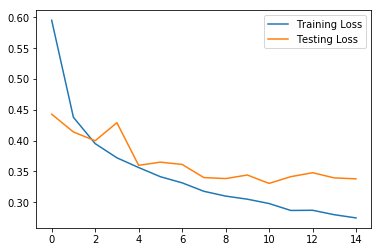

In [8]:
#plotting the training and testing loss that we have stored.
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.legend();

If you have seen the graph from the previous notebook `Fashion MNIST`, then is a lot better thant that. In that notebook, since we haven't used the `Dropout`, our model will overfit after sometime and hence our validation or testing loss increases. Here since we have used `Dropout` our testing loss decreases gradually.

Sandal


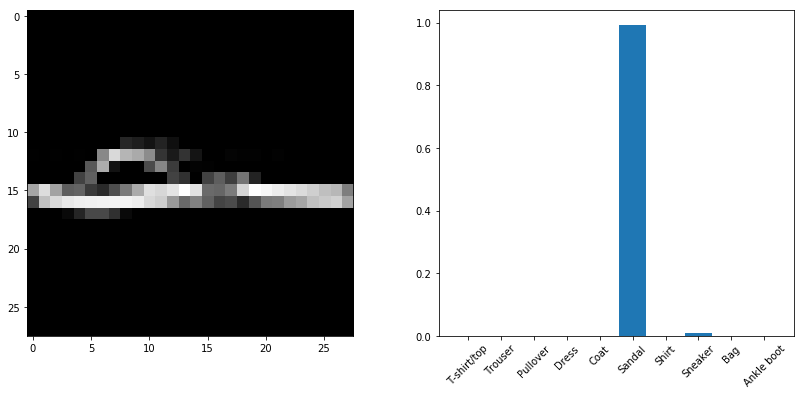

In [9]:
#Here we plot the image and the prediction from the output. 

#gets the images and labels
images, labels = next(iter(testloader))
img = images[0].view(1,-1)

#passes the images from the model
logits = torch.exp(model(img))



plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')

y = logits.detach().numpy()
N = y.shape[1]
x = np.arange(N)

plt.subplot(1,2,2)
plt.bar(x,y.squeeze())
xl = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.xticks(x,xl, rotation=45);

print(xl[labels[0].item()])